# 03_Modeling

https://scikit-learn.org/stable/modules/mixture.html

## Imports

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import umap
import joblib
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from visualization import compare_gmm_params,plot_gmm_metrics_comparison

## Load data

In [37]:
df = pd.read_csv('../data/preprocessed_datasets/windowed_dataset_cleaned.csv')
X = df[df.columns.difference(['is_attack'])]
y = df['is_attack']

## GMM

### Selecting Hyperparameters

Aplicando transformaciones a los datos...
Procesando n_components=2...
Procesando n_components=3...
Procesando n_components=4...
Procesando n_components=5...
Procesando n_components=6...
Procesando n_components=7...


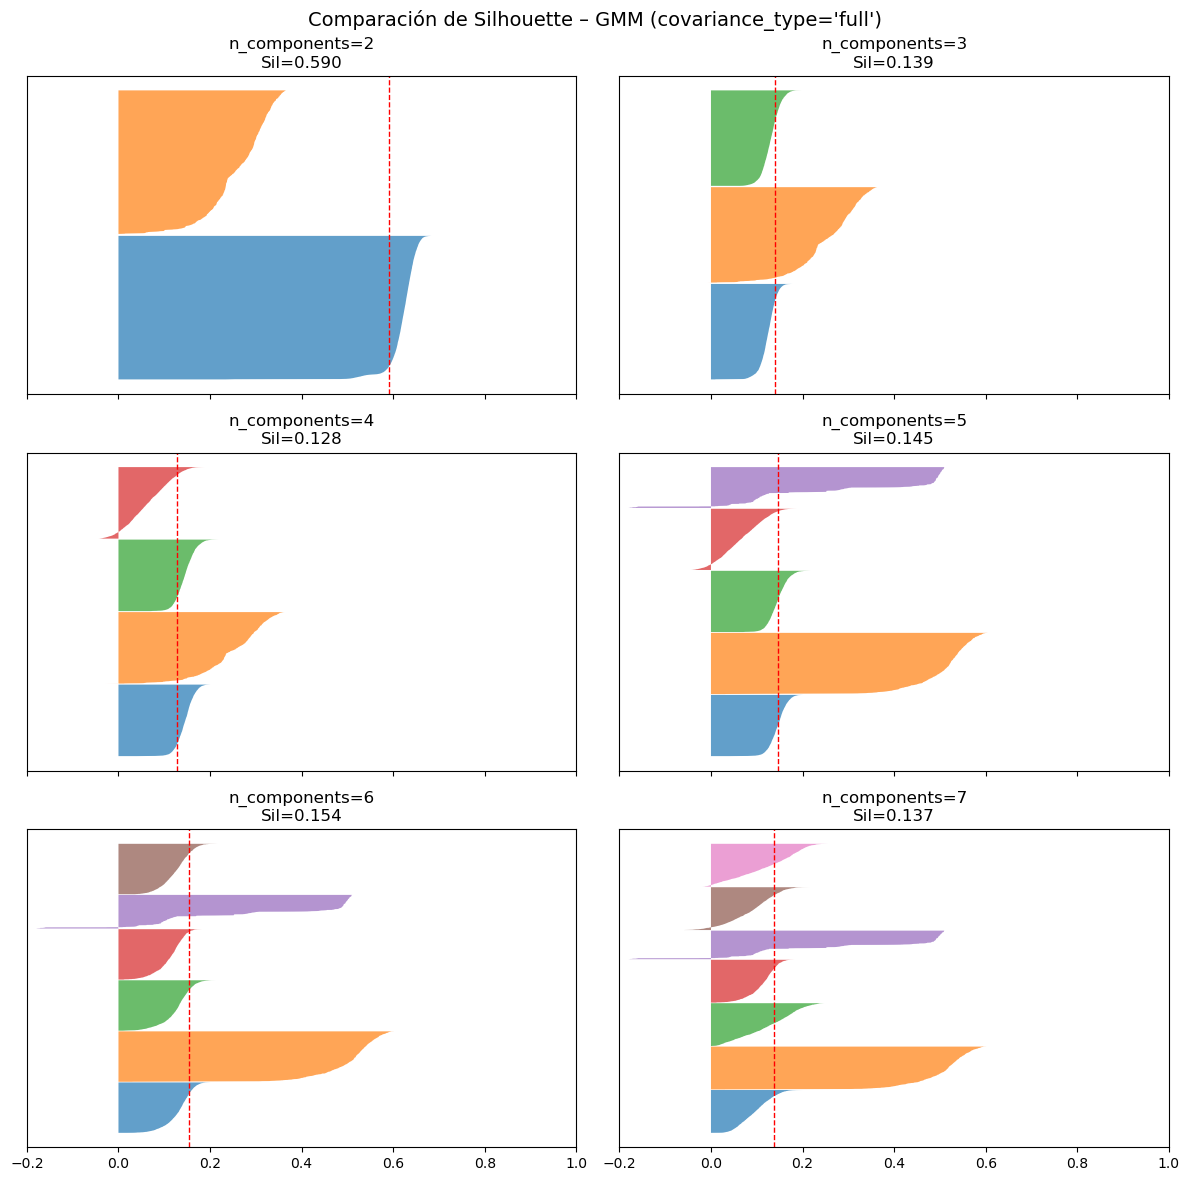

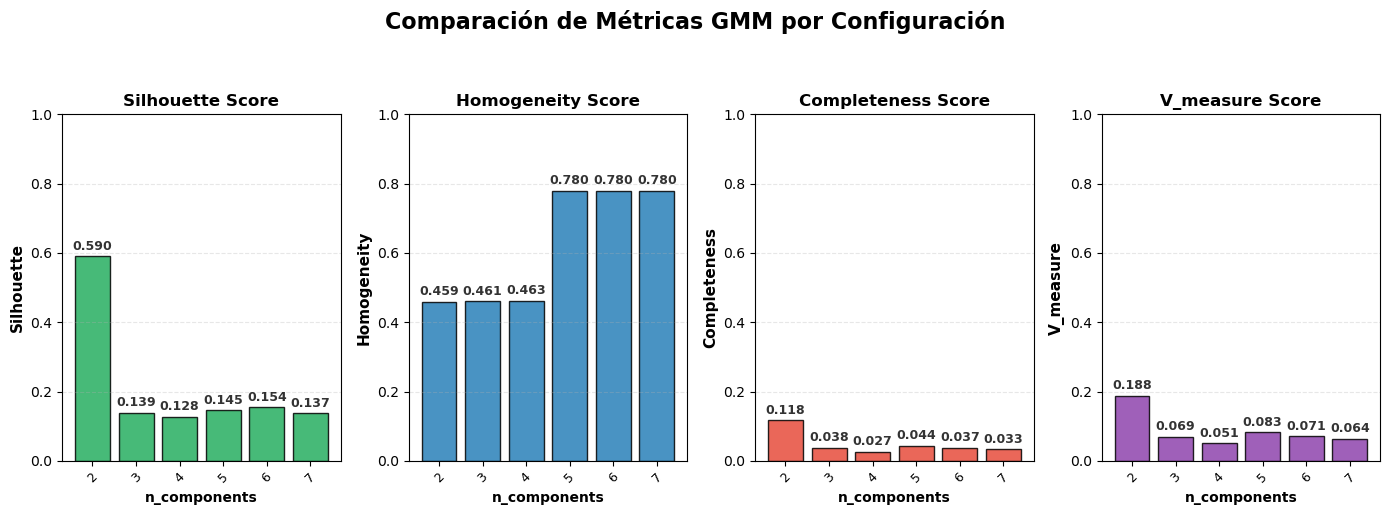

In [38]:
param_grid = [2, 3, 4, 5, 6, 7]

# Ejecuta la comparación
results, fig1 = compare_gmm_params(
    X, 
    param_grid,
    y_true=y,  # opcional
    covariance_type='full',  # puedes cambiar a 'tied', 'diag', 'spherical'
    random_state=42
)
plt.show()

# Visualiza las métricas
fig2 = plot_gmm_metrics_comparison(results)
plt.show()

- We want to keep the model hyperparameters which will give the highest scores in different metrics. Using **n_components=3** fullfills this requirement.
- In every case, the model cannot assure good **cohesion** and **separation**, within and between clusters. 
- The silhouette scores are high but this happens because most of the points are part of the biggest cluster. If we take a look to the **Silhouette Graphics** we can see that many clusters have point with a lower than 0 score which means that they are closer to the closest clusters than to their own cluster.

### Fitting the model

In [39]:
'''gmm = GaussianMixture(
    n_components=2, # número de clusters
    covariance_type='full', # 'full', 'tied', 'diag', 'spherical' full: clusters = elipses libres (cualquier forma)
    reg_covar=1e-6,
    random_state=42
)'''
#gmm_labels = gmm.fit_predict(X)
gmm_pipeline = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson', standardize=False)),  # Normaliza distribuciones asimétricas
    ('scaler', StandardScaler()),  # Escala a media=0, std=1
    ('gmm', GaussianMixture(
        n_components=2,  # número de clusters
        covariance_type='full',  # 'full', 'tied', 'diag', 'spherical' full: clusters = elipses libres
        reg_covar=1e-6,
        random_state=42
    ))
])

gmm_labels = gmm_pipeline.fit_predict(X)

### Visualizing the results: PCA & UMAP

In [40]:
pca_pipeline = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2, random_state=42))
])

X_pca = pca.fit_transform(X)

print("Varianza explicada por componente:")
print(pca.explained_variance_ratio_)
print("Varianza total explicada:", pca.explained_variance_ratio_.sum())

df_pca = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'GMM_cluster': gmm_labels.astype(str),
    'is_attack': y
})

fig = px.scatter(
    df_pca,
    x='PCA1',
    y='PCA2',
    color='GMM_cluster',
    title="PCA (2D) – Gaussian Mixture clusters",
    width=900,
    hover_data=['is_attack'],
    height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(legend_title_text='GMM Cluster')

fig.show()


Varianza explicada por componente:
[0.95108786 0.03797685]
Varianza total explicada: 0.9890647106267866


- We can see how the model is able to create 2 clear clusters but we will find that in the 2nd cluster many attack and legitimate traffic are mixed.

In [41]:
import umap

umap_pipeline = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler()),
    ('umap', umap.UMAP(
        n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=42
    ))
])


X_umap = umap_pipeline.fit_transform(X)


/Users/taxi/miniconda3/envs/consoning/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [42]:
import plotly.express as px

df_vis = df.copy()
df_vis['UMAP1'] = X_umap[:, 0]
df_vis['UMAP2'] = X_umap[:, 1]
df_vis['gmm_cluster'] = gmm_labels.astype(str)

fig = px.scatter(
    df_vis,
    x='UMAP1',
    y='UMAP2',
    color='gmm_cluster',
    hover_data=['is_attack', 'burst_score_max', 'conn_count_10s_max', 'recent_activity_score_std', 'time_since_container_start_std', 'total_conn_from_ip_std'],
    title="UMAP + Gaussian Mixture clusters",
    width=900,
    height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(legend_title_text='GMM cluster')

fig.show()


- The model sees a big central cluster and 2 smaller clusters that look like curves which might seem good
- As the attacks are very close to some network traffic instances the model clusters them together and is not able to make a difference. (zoom bottom right corner)

### Semisupervised results

In [43]:
pd.crosstab(df['is_attack'], gmm_labels)

col_0,0,1
is_attack,,
0,21930,1729
1,6,340


- As we have seen, the model clusters together the attacks but can't make the difference with some traffic instances. Let's analyze the Cluster 1 where every attack is clustered with other network traffic

### Visualizng by cluster

In [44]:
# Define the two GMM clusters
cluster0 = df_vis[df_vis['gmm_cluster'] == '0'].copy()
cluster1 = df_vis[df_vis['gmm_cluster'] == '1'].copy()

# Split cluster1 into legit and attack
cluster1_legit = cluster1[cluster1['is_attack'] == 0].copy()
cluster1_attack = cluster1[cluster1['is_attack'] == 1].copy()

# Count real attacks (for transparency)
n_attacks_c0 = cluster0['is_attack'].sum()  # should be 6
n_legit_c1 = len(cluster1_legit)
n_attack_c1 = len(cluster1_attack)

print(f"Cluster 0: {len(cluster0):>6} samples ({n_attacks_c0} attacks) → treated as LEGITIMATE")
print(f"Cluster 1 - Legitimate: {n_legit_c1:>6} samples")
print(f"Cluster 1 - Attack:     {n_attack_c1:>6} samples")
print("="*80)

# Key features for comparison
features = [
    'burst_score_max',
    'conn_count_10s_max',
    'conn_count_60s_max',
    'ja3_frequency_mean',
    'recent_activity_score_std',
    'time_since_container_start_std',
    'bytes_ratio_mean'
]

# Central tendency: mean for all groups
comparison_data = []
for feature in features:
    comparison_data.append({
        'Feature': feature,
        'C0 (Legit)': cluster0[feature].mean(),
        'C1_Legit': cluster1_legit[feature].mean(),
        'C1_Attack': cluster1_attack[feature].mean()
    })

# Variability: standard deviation for all groups
std_data = []
for feature in features:
    std_data.append({
        'Feature': feature,
        'C0 (Legit)': cluster0[feature].std(),
        'C1_Legit': cluster1_legit[feature].std(),
        'C1_Attack': cluster1_attack[feature].std()
    })

comparison_df = pd.DataFrame(comparison_data)
std_df = pd.DataFrame(std_data)

print("\nCOMPARISON TABLE (CENTRAL TENDENCY):")
print("(C0 treated as pure legitimate; C1 split by true label)")
print("="*80)
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

print("\nSTANDARD DEVIATION (VARIABILITY) BY GROUP:")
print("="*80)
print(std_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*80)

Cluster 0:  21936 samples (6 attacks) → treated as LEGITIMATE
Cluster 1 - Legitimate:   1729 samples
Cluster 1 - Attack:        340 samples

COMPARISON TABLE (CENTRAL TENDENCY):
(C0 treated as pure legitimate; C1 split by true label)
                       Feature  C0 (Legit)  C1_Legit  C1_Attack
               burst_score_max      0.0011    0.1134     1.0000
            conn_count_10s_max      1.0330    1.9717     7.2676
            conn_count_60s_max      1.4664    2.5246     7.3500
            ja3_frequency_mean     68.1104   68.7149   392.5147
     recent_activity_score_std      0.0000    0.0736     0.2769
time_since_container_start_std      0.0000    2.2365     0.0000
              bytes_ratio_mean      0.5393    0.5164     0.2206

STANDARD DEVIATION (VARIABILITY) BY GROUP:
                       Feature  C0 (Legit)  C1_Legit  C1_Attack
               burst_score_max      0.0331    0.3171     0.0000
            conn_count_10s_max      0.1855    0.3876     2.2555
            conn_c

In [45]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Features más discriminantes
discriminant_features = [
    'ja3_frequency_mean',
    'conn_count_10s_max', 
    'burst_score_max',
    'bytes_ratio_mean',
    'recent_activity_score_std'
]

def format_value(v):
    if v == 0:
        return "0"
    elif abs(v) >= 1e-3:
        return f"{v:.4f}"
    else:
        return f"{v:.2e}"

fig_bars = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f.replace('_', ' ').title() for f in discriminant_features],
    vertical_spacing=0.12,
    horizontal_spacing=0.10
)

# Updated group names (3 groups only)
group_names = ['C0 (Legit)', 'C1_Legit', 'C1_Attack']
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # removed blue for C1

for idx, feature in enumerate(discriminant_features):
    row = idx // 3 + 1
    col = idx % 3 + 1
    
    # Fetch values from the updated comparison_df
    values = [
        comparison_df[comparison_df['Feature'] == feature]['C0 (Legit)'].values[0],
        comparison_df[comparison_df['Feature'] == feature]['C1_Legit'].values[0],
        comparison_df[comparison_df['Feature'] == feature]['C1_Attack'].values[0]
    ]
    
    # Adjust Y-axis range
    max_val = max(values)
    y_max = max(0.001, max_val * 1.2) if max_val > 0 else 0.001
    fig_bars.update_yaxes(range=[0, y_max], row=row, col=col)
    
    for i, (group, value, color) in enumerate(zip(group_names, values, colors)):
        fig_bars.add_trace(
            go.Bar(
                x=[group],
                y=[value],
                name=group if idx == 0 else None,
                marker_color=color,
                text=[format_value(value)],
                textposition='outside',
                textfont=dict(size=10, color='black'),
                showlegend=(idx == 0),
                hovertemplate=f'<b>{group}</b><br>{feature}: %{{y:.6f}}<extra></extra>'
            ),
            row=row, col=col
        )

fig_bars.update_xaxes(showticklabels=True)  # optional: show group labels
fig_bars.update_yaxes(title_text="Valor", col=1)

fig_bars.update_layout(
    title_text='Features Clave: Comparación de los 3 Grupos',
    title_font_size=16,
    height=600,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    plot_bgcolor='white',
    paper_bgcolor='#f8f9fa'
)

fig_bars.show()

## Conclusions

#### Custer 0
- We can see that most of the samples are in the 0 cluster, which represent the legitimate, normal, usual traffic to Consul.

- If we take a look to the average values of this cluster, we can see that the **burst_scores** are significantly lower. So are the number of connections in 10 and 60 seconds (**conn_count_10s_max & conn_count_60s_max**). 

- In addition, the **ja3 frequency** is much lower in these samples. As we know, our service use HttpxClient for fetching the Consul. Here, the TLS handshake is reused in the same connection, so the ja3 frequency can't be too high as there are no many different connexions with the same TLS handshake.

In conclusion, everything suggests that these samples are GET requests to the consul *(https://consul_ip/v1/catalog/service/order)* of a concrete service or single healthchecks.

#### Cluster 1
- This is the 2nd biggest cluster. It shows higher **burst_score**, **conn_count_60s_max** and **recent_activity_score_std**. 

- This suggest that the traffic in this cluster is a bit more intense like faster healthcheacks when a service just started or when a service crushes where Consul sends a bigger amount of heealthcheck in a higher frequency. 

- Some samples might also be a part of the process where more GETs are done. Between machine and order for example. *the services do not save data in cache, every time they need a service ip they will ask it to Consul*

#### Cluster 2: Legitimate connexions and attacks
- Within this cluster, **burst_score_max, conn_count_10s_max** are much higher. This shows that the frequency of paquets if very high, make bursts. We know that after registering in Consul many healthcheck are done in a row. 

- We also see that the **bytes_ratio** is much lower for the attacking instances. Remembering that, *bytes_ratio = orig_bytes / resp_bytes*, this suggests that the size of the packets sent by the attacker are small comparing to the response. This suggest the scan pattern where the attackers fetches every services registered: *(https://consul_ip/v1/catalog/services)* or *(https://consul_ip/v1/catalog/nodes)*

- When it comes to ja3_frecuency, the attack samples in this cluster show very high values. This is usually related to an automated tool that is creating new connections every time with the same TLS handshake. the legitimate services keep the same connexion opened via *keep-alive*. The legitimate samples of this cluster have a slightly higher ja3 frecuency as the services may create a new conexion when (re)starting/registering.

- Finally by the nature of self-registering (register+verify/healthchecks) in Consul and attacking pattern scan-register-verify/healthchecks we can understand the similarity between these samples and their proximity when plotting in 2D. the model has difficulties separating these two.

## Save model

In [ ]:
joblib.dump(gmm_pipeline, "../models/gmm_model.joblib")

StandardScaler()
